In [1]:

%matplotlib notebook

import numpy as np
from scipy.stats import multivariate_normal
from multitools import set_cam_poses, set_vir_poses
from multitools import get_transmats, get_rotmats
from multitools import get_b_pose_from_a_pose, get_angles
from multitools import visualize_all_cigars


if __name__ == '__main__':
            
    # Stats in virtual space
    w_pose = np.array([-0.35, 0.1, 0.4])    
    
    # Get camera poses
    r_poses = set_cam_poses()
    
    # Get Rotation Matrices: real-cam to world 
    r2w = get_rotmats(r_poses)
    
    # Get Translation Matrices: real-cam to world
    r_trl = get_transmats(r_poses)
        
    # Get poses and angles of connecting ray vs Z axis in real-cam space
    r_poses = np.zeros((3,3))       
    r_angles = np.zeros((2,3))    
    for k in range(3):
        r_poses[:,k] = get_b_pose_from_a_pose(r2w[:,:,k], r_trl[:,:,k], w_pose)
        r_angles[0:2, k] = get_angles(r_poses[:,k])
            
    # Estimate virtual camera poses (in real camera space)
    v_poses = set_vir_poses(r_angles)
        
    # Get Rotation Matrices: virtual-cam to real-cam 
    v2r = get_rotmats(v_poses)
        
    # Get poses in virtual-cam space
    v_poses = np.zeros((3,3))  
    v_angles = np.zeros((2,3))    
    for k in range(3):
        v_poses[:,k] = get_b_pose_from_a_pose(v2r[:,:,k], np.identity(4), r_poses[:,k])
        v_angles[0:2, k] = get_angles(v_poses[:,k])



    #############################################################################################
    #                                THIS is the 'starting point'                               #
    #############################################################################################

    # Original covariance matrix in virtual camera space
    μ = np.array([0,0,-0.6])
    Σ = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.3]])
    
   
    r_μ = np.zeros((3,3))
    r_Σ = np.zeros((3,3,3))
    w_μ = np.zeros((3,3))
    w_Σ = np.zeros((3,3,3))
    new_μ = np.zeros((4,3)) # including a '1' at the end
    for k in range(3):       
                     
        # Rotating Means from virtual-cam space to real-cam space  
        r_μ[:,k] = v2r[:,:,k] @ μ
                 
        # Rotating Means from real-cam space to world space 
        w_μ[:,k] = r2w[:,:,k] @ r_μ[:,k]
    
        # Translating Means from Camera (Real=Virtual) space to World space 
        new_μ[:,k] = r_trl[:,:, k] @ [w_μ[0,k], w_μ[1,k], w_μ[2,k],1]                     
                 
        # Rotating Covariance Matrix from virtual-cam space to real-cam space  
        r_Σ[:,:,k] = v2r[:,:,k] @ Σ @ v2r[:,:,k].T  
                 
        # Rotating Covariance Matrix from real-cam space to world space  
        w_Σ[:,:,k] = r2w[:,:,k] @ r_Σ[:,:,k] @ r2w[:,:,k].T 
    
    rv_1 = multivariate_normal(new_μ[0:3,0], w_Σ[:,:,0])
    rv_2 = multivariate_normal(new_μ[0:3,1], w_Σ[:,:,1])
    rv_3 = multivariate_normal(new_μ[0:3,2], w_Σ[:,:,2])
    

In [2]:
threshold = 2
nb_pts = 100

<IPython.core.display.Javascript object>


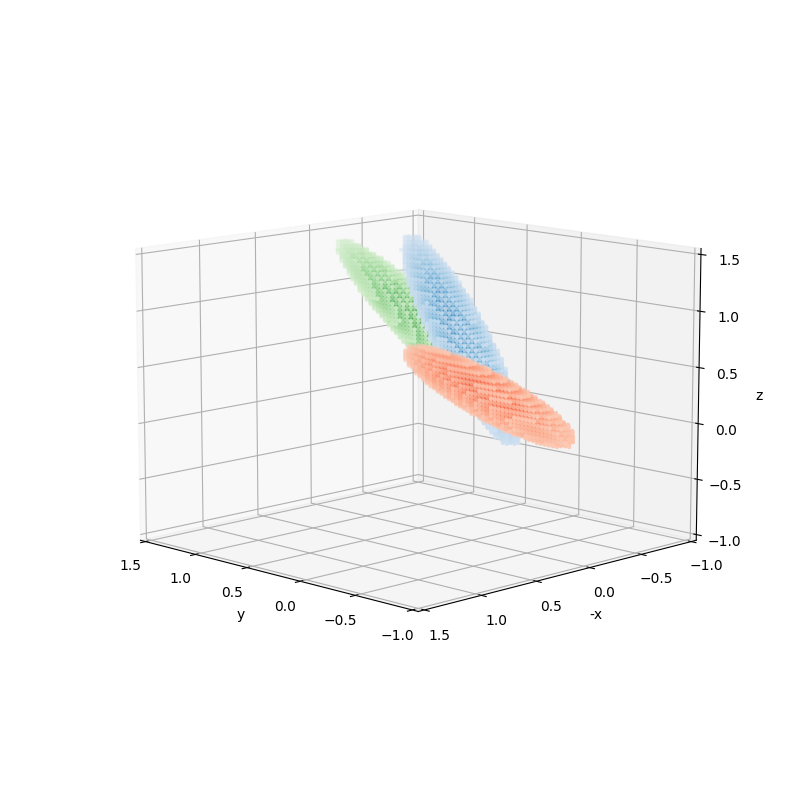

Joint probabilities obtained after: 15 seconds.
Joint probabilities obtained after: 15 seconds.
Joint probabilities obtained after: 15 seconds.


In [3]:
visualize_all_cigars(nb_pts, rv_1, rv_2, rv_3, new_μ[0:3,:], threshold)